In [ ]:
# Run this if you get "module not found" errors later.
!pip install -q scikit-learn pandas matplotlib statsmodels joblib


In [ ]:
# Option A: Upload CSV directly (recommended for beginners)
from google.colab import files
import io, pandas as pd

print("Choose the CSV file from your computer (Housing.csv or similar).")
uploaded = files.upload()  # choose file from dialog

# Load first uploaded file
fname = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[fname]))
print("Loaded:", fname)
print("Shape:", df.shape)


Choose the CSV file from your computer (Housing.csv or similar).


Saving Housing.csv to Housing.csv
Loaded: Housing.csv
Shape: (545, 13)


In [ ]:
# Basic EDA
import numpy as np
pd.set_option('display.max_columns', 120)

print("First 5 rows:")
display(df.head())

print("\nInfo:")
print(df.info())

print("\nDescribe (numeric):")
display(df.describe().T)

print("\nMissing values per column:")
display(df.isnull().sum().sort_values(ascending=False).head(20))


First 5 rows:


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None

Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
price,545.0,4.766729e+06,1.870440e+06,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0
area,545.0,5.150541e+03,2.170141e+03,1650.0,3600.0,4600.0,6360.0,16200.0
bedrooms,545.0,2.965138e+00,7.380639e-01,1.0,2.0,3.0,3.0,6.0
bathrooms,545.0,1.286239e+00,5.024696e-01,1.0,1.0,1.0,2.0,4.0
stories,545.0,1.805505e+00,8.674925e-01,1.0,1.0,2.0,2.0,4.0
parking,545.0,6.935780e-01,8.615858e-01,0.0,0.0,0.0,1.0,3.0



Missing values per column:


,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [ ]:
# CHANGE this if your target column has a different name (e.g., 'SalePrice' or 'Price')
TARGET = 'price'   # <- edit to match your dataset

if TARGET not in df.columns:
    print("WARNING: target", TARGET, "not found. Columns available:")
    print(list(df.columns))
    # stop or continue after editing TARGET
else:
    # Drop unnamed index column(s) if present
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    # Ensure target is numeric
    df[TARGET] = pd.to_numeric(df[TARGET], errors='coerce')
    print("Target dtype:", df[TARGET].dtype, "  Nulls in target:", df[TARGET].isnull().sum())


Target dtype: int64   Nulls in target: 0


In [ ]:
# Separate numeric & categorical (simple approach)
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

# Remove target from num_cols if present
if TARGET in num_cols:
    num_cols.remove(TARGET)

print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))

# Fill numeric NaN with median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical NaN with mode (if any)
for c in cat_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

# One-hot encode categoricals (drop_first avoids dummy trap)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("Shape after encoding:", df.shape)


Numeric cols: 5 Categorical cols: 7
Shape after encoding: (545, 14)


In [ ]:
from sklearn.model_selection import train_test_split

# Make sure target exists & drop rows with NaN target
df = df.dropna(subset=[TARGET])
X = df.drop(TARGET, axis=1)
y = df[TARGET]

# Optional: reduce number of features if extremely large (you can skip)
# X = X.loc[:, X.columns[:200]]  # example to keep first 200 features only

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (436, 13) Test shape: (109, 13)


In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

model = LinearRegression()
model.fit(X_train, y_train)

print("Model fitted.")
print("Intercept:", model.intercept_)


Model fitted.
Intercept: 260032.35760741215


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")


MAE: 970043.4039
MSE: 1754318687330.6638
RMSE: 1324506.9601
R^2: 0.6529


In [ ]:
coef_df = (
    pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
      .assign(abs_coef=lambda d: d['coefficient'].abs())
      .sort_values('abs_coef', ascending=False)
)
display(coef_df.head(25))
# Interpretation: positive coef -> feature increases price, negative -> decreases price.


,feature,coefficient,abs_coef
2,bathrooms,1.094445e+06,1.094445e+06
9,airconditioning_yes,7.914267e+05,7.914267e+05
8,hotwaterheating_yes,6.846499e+05,6.846499e+05
10,prefarea_yes,6.298906e+05,6.298906e+05
12,furnishingstatus_unfurnished,-4.136451e+05,4.136451e+05
3,stories,4.074766e+05,4.074766e+05
7,basement_yes,3.902512e+05,3.902512e+05
5,mainroad_yes,3.679199e+05,3.679199e+05
6,guestroom_yes,2.316100e+05,2.316100e+05
4,parking,2.248419e+05,2.248419e+05


Top single feature by absolute correlation with target: price


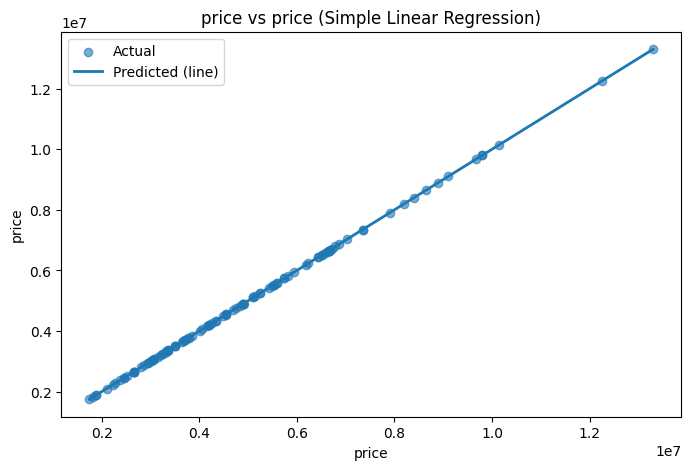

Simple model R^2: 1.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Find top numeric feature correlated with target
numeric_all = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in numeric_all:
    numeric_all.remove(TARGET)

corrs = df[numeric_all + [TARGET]].corr()[TARGET].abs().sort_values(ascending=False)
top_feature = corrs.index[0]
print("Top single feature by absolute correlation with target:", top_feature)

# Simple model using only top_feature
X_s = df[[top_feature]]
y_s = df[TARGET]
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
simple_model = LinearRegression().fit(X_s_train, y_s_train)
y_s_pred = simple_model.predict(X_s_test)

# Plot scatter + regression line (sorted for nice line)
idx = np.argsort(X_s_test[top_feature].values.squeeze())
plt.figure(figsize=(8,5))
plt.scatter(X_s_test[top_feature], y_s_test, alpha=0.6, label='Actual')
plt.plot(X_s_test[top_feature].values.squeeze()[idx], y_s_pred[idx], linewidth=2, label='Predicted (line)')
plt.xlabel(top_feature)
plt.ylabel(TARGET)
plt.title(f"{top_feature} vs {TARGET} (Simple Linear Regression)")
plt.legend()
plt.show()

print("Simple model R^2:", r2_score(y_s_test, y_s_pred))


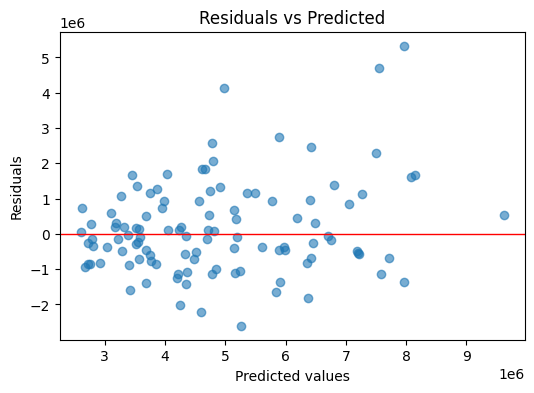

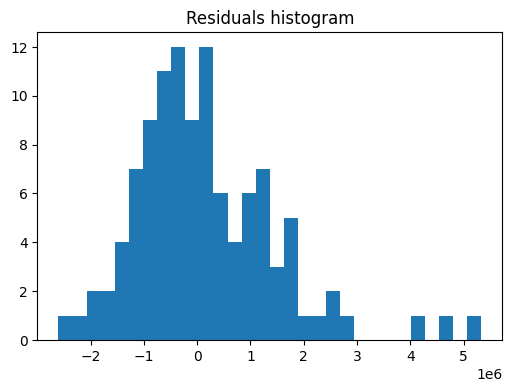

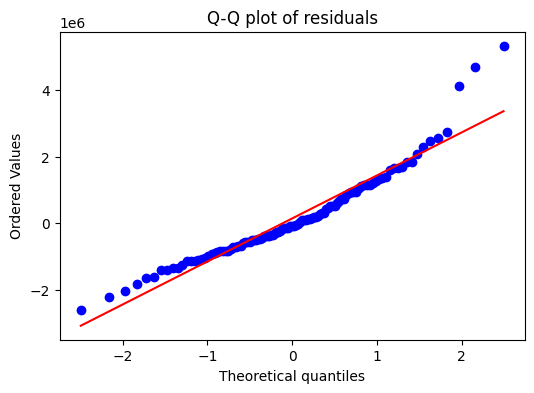

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

residuals = y_test - y_pred

# Residuals vs predicted (look for no pattern -> homoscedasticity)
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linewidth=1)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

# Histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title('Residuals histogram')
plt.show()

# Q-Q plot for normality
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot of residuals')
plt.show()


In [ ]:
# Compute VIF for top numeric features only (faster)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# select numeric features (you can limit to top K most correlated to target)
num_feats = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in num_feats:
    num_feats.remove(TARGET)

# Use top 10 numeric features by correlation to target for VIF
top_num = corrs.index[:10].tolist()  # corrs computed earlier
print("Computing VIF for:", top_num)

X_vif = df[top_num].dropna()
vif_data = []
for i in range(X_vif.shape[1]):
    vif = variance_inflation_factor(X_vif.values, i)
    vif_data.append((X_vif.columns[i], vif))

vif_df = pd.DataFrame(vif_data, columns=['feature', 'VIF']).sort_values('VIF', ascending=False)
display(vif_df)


Computing VIF for: ['price', 'area', 'bathrooms', 'stories', 'parking', 'bedrooms']


,feature,VIF
0,price,17.110853
5,bedrooms,13.766850
2,bathrooms,10.718360
1,area,8.895295
3,stories,7.463489
4,parking,2.017673


In [ ]:
import joblib
joblib.dump(model, 'linear_model.pkl')
print("Saved linear_model.pkl")
from google.colab import files
files.download('linear_model.pkl')  # triggers browser download


Saved linear_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>